## ⚙️ Import Libraries

In [ ]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np
import pandas as pd

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)
from datetime import datetime

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import hashlib
from collections import defaultdict
import matplotlib.pyplot as plt

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

In [ ]:
# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
#LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 1000

# Set data split size for training and validation
SPLITS_SIZE = 0.2

## ⏳ Load and Process Data

In [ ]:
# Load the dataset
print("Loading Mars dataset...")
data = np.load("/kaggle/input/mars-training-set/mars_for_students.npz")
training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]
X_test = data["test_set"]

# Add a channel
X_train = X_train[..., np.newaxis]
y_train = y_train[..., np.newaxis]
X_test = X_test[..., np.newaxis] 

print("Dataset loaded!")

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"\nInput shape: {input_shape}")
print(f"Number of classes: {num_classes}")

print(f"\nShape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

In [ ]:
# Randomly select 16 indices from the dataset
random_indices = np.random.choice(len(X_train), 16, replace=False)

# Create a 4x4 grid to display the images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    # Fetch a random image using the random indices
    random_image = X_train[random_indices[i]]
    
    # Handle potential dimension issues
    if random_image.ndim == 3:  # If there's a singleton dimension
        random_image = random_image.squeeze()
    
    # Normalize pixel values if necessary
    random_image = random_image / 255.0 if random_image.max() > 1 else random_image
    
    # Display the grayscale image
    ax.imshow(random_image, cmap='gray', vmin=0., vmax=1.)
    ax.axis('off')
    ax.set_title(f"image {random_indices[i]}")

# Adjust layout and display the images
plt.tight_layout()
plt.show()

In [ ]:
# search for duplicates

# Function to calculate the hash of an image
def calculate_image_hash(image):
    return hashlib.md5(image.tobytes()).hexdigest()

# Calculate hashes for each image and store their indices
hash_dict = defaultdict(list)
for idx, image in enumerate(y_train):
    img_hash = calculate_image_hash(image)
    hash_dict[img_hash].append(idx)

# Find duplicates
duplicates = {key: indices for key, indices in hash_dict.items() if len(indices) > 1}

if duplicates:
    print("Duplicate images found!")
    
   
    num_duplicates = len(duplicates)
    cols = 5 
    rows = (num_duplicates + cols - 1) // cols  
    
    # Create the figure and subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axes = axes.flatten()  
    
    for i, (img_hash, indices) in enumerate(duplicates.items()):
        # Select one representative image
        representative_idx = indices[0]
        occurrence_count = len(indices)  
        ax = axes[i]
        
        # Plot the image
        if y_train[representative_idx].ndim == 3: 
            ax.imshow(y_train[representative_idx])
        else: 
            ax.imshow(y_train[representative_idx], cmap='gray')
        
        # Set title with hash, occurrences, and first index
        ax.set_title(f"Idx: {representative_idx}, Count: {occurrence_count}")
        ax.axis('off')
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

else:
    print("No duplicate images found!")

In [ ]:
# Function to calculate the hash of an image
def calculate_image_hash(image):
    return hashlib.md5(image.tobytes()).hexdigest()

# Calculate hashes for each image and store their indices
hash_dict = defaultdict(list)
for idx, image in enumerate(y_train):
    img_hash = calculate_image_hash(image)
    hash_dict[img_hash].append(idx)

# Function to get images associated with a specific index
def get_images_by_index(index):
    # Calculate the hash of the image at the specific index
    img_hash = calculate_image_hash(y_train[index])
    
    # Get the indices associated with the hash
    associated_indices = hash_dict.get(img_hash, [])
    
    return img_hash, associated_indices

# Delete only the aliens
index_of_interest = 62 

# Get images associated with the hash of the specified index
img_hash, associated_indices = get_images_by_index(index_of_interest)

# Check if duplicates exist for the given hash
if associated_indices:
    print(f"Hash for image at index {index_of_interest}: {img_hash}")
    
    # Determine the number of images associated with this hash
    num_images = len(associated_indices)
    cols = 5  # Number of columns for displaying images
    rows = (num_images + cols - 1) // cols  # Number of rows needed for display
    
    # Create the figure and subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axes = axes.flatten()  # Flatten the axes array to make indexing easier
    
    for i, idx in enumerate(associated_indices):
        # Plot the image
        ax = axes[i]
        if y_train[idx].ndim == 3:  # Check if image has 3 channels (RGB)
            ax.imshow(X_train[idx])
        else:  # For grayscale images
            ax.imshow(X_train[idx], cmap='gray')
        
        # Set title with index
        ax.set_title(f"Idx: {idx}")
        ax.axis('off')
    
    # Hide any unused subplots if the number of images is less than the total axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

else:
    print(f"No duplicates found for image at index {index_of_interest}.")

In [ ]:
# remove outliers

X_train = np.delete(X_train, associated_indices, axis=0)
y_train = np.delete(y_train, associated_indices, axis=0)

print("Dataset dimension after deleting outliers: ", X_train.shape[0])

In [ ]:
# Split the training set into training and validation sets
print("Splitting data...")
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=SPLITS_SIZE, random_state=seed
)
print("Data splitted!")

# Display dataset information
print(f"\nNumber of images:")
print(f"Training set: {len(X_train)}")
print(f"Validation set: {len(X_val)}")
print(f"Test set: {len(X_test)}")

In [126]:
# Define the category mapping
category_map = {
        0: 0,  # background
        1: 1,  # soil
        2: 2,  # bedrock
        3: 3,  # sand
        4: 4   # big rock
}

# Define the classes 
classes = ['background', 'soil', 'bedrock', 'sand', 'big rock'] 

NUM_CLASSES = len(set(category_map.values()))
print(f"Number of categories: {len(category_map)}")

Number of categories: 5


In [ ]:
def preprocess_data(X, y, input_size=(64, 128)):
    X = tf.image.resize(X, input_size)
    X = tf.cast(X, tf.float32) / 255.0
    
    y = tf.image.resize(y, input_size, method='bilinear')
    y = tf.cast(y, tf.int32)
    return X, y

In [ ]:
def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)

In [ ]:
# Define augmentation
@tf.function
def random_flip(image, label, seed=None):
    """Consistent random horizontal flip."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    return image, label

In [ ]:
def make_dataset(X, y, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a TensorFlow dataset. 
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((X, y)) #create data from images and masks

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed) #we can shuffle it

    # Preprocess immages and labels
    dataset = dataset.map(
        preprocess_data,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    # Apply category mapping: change the labels
    dataset = dataset.map(
        lambda x, y: (x, apply_category_mapping(y)),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if augment: #apply random flip
        dataset = dataset.map(
            lambda x, y: random_flip(x, y, seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    # Batch the data (do it now and not at training time)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [ ]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    X_train, y_train, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=seed
)

val_dataset = make_dataset(
    X_val, y_val,
    batch_size=BATCH_SIZE,
    shuffle=False #for validation not necessary to shuffle it
)
print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

In [134]:
def create_segmentation_colormap(num_classes): 
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

# Apply the colormap to labels with safety check
def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label with bounds checking.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    # Ensure label values are in the valid range [0, num_classes-1]
    num_classes = len(colormap)  # Get the number of classes from the colormap
    label = np.clip(label, 0, num_classes - 1)  # Clip values to be within range

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

# Plot real image and ground truth (reduced resolution)
def plot_sample_batch(dataset, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(15, 4 * num_samples))

    for images, labels in dataset.take(1):
        labels_np = labels.numpy()
        num_classes = len(category_map)  # Ensure colormap covers all classes, including the background
        colormap = create_segmentation_colormap(num_classes)

        for j in range(min(num_samples, len(images))):
            # Plot original grayscale image (no colormap)
            plt.subplot(num_samples, 2, j * 2 + 1)
            plt.imshow(images[j], cmap='gray')  # Use 'gray' cmap for the images (ensure grayscale)
            plt.title(f'Image {j + 1}')
            plt.axis('off')

            # Plot colored label (apply colormap only to labels)
            plt.subplot(num_samples, 2, j * 2 + 2)
            colored_label = apply_colormap(labels_np[j], colormap)  # Apply colormap to the labels only
            plt.imshow(colored_label)  # Show the colored label
            plt.title(f'Label {j + 1}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

    handles = []
    # After all images have been plotted, add the legend once
    # We collect handles for the legend here, only once
    for label_idx in category_map:
        color = colormap[label_idx]  # Use array indexing, subtracting 1 to account for class 0 exclusion
        handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=classes[label_idx]))
    
    # Create a single legend displayed at the bottom
    fig, ax = plt.subplots(figsize=(10, 2))  # Make the figure wide enough for a horizontal legend
    ax.legend(handles=handles, loc='center', bbox_to_anchor=(0.5, 0), title="Classes", ncol=len(category_map))
    ax.axis('off')
    plt.show()

Visualizing examples from the training set:


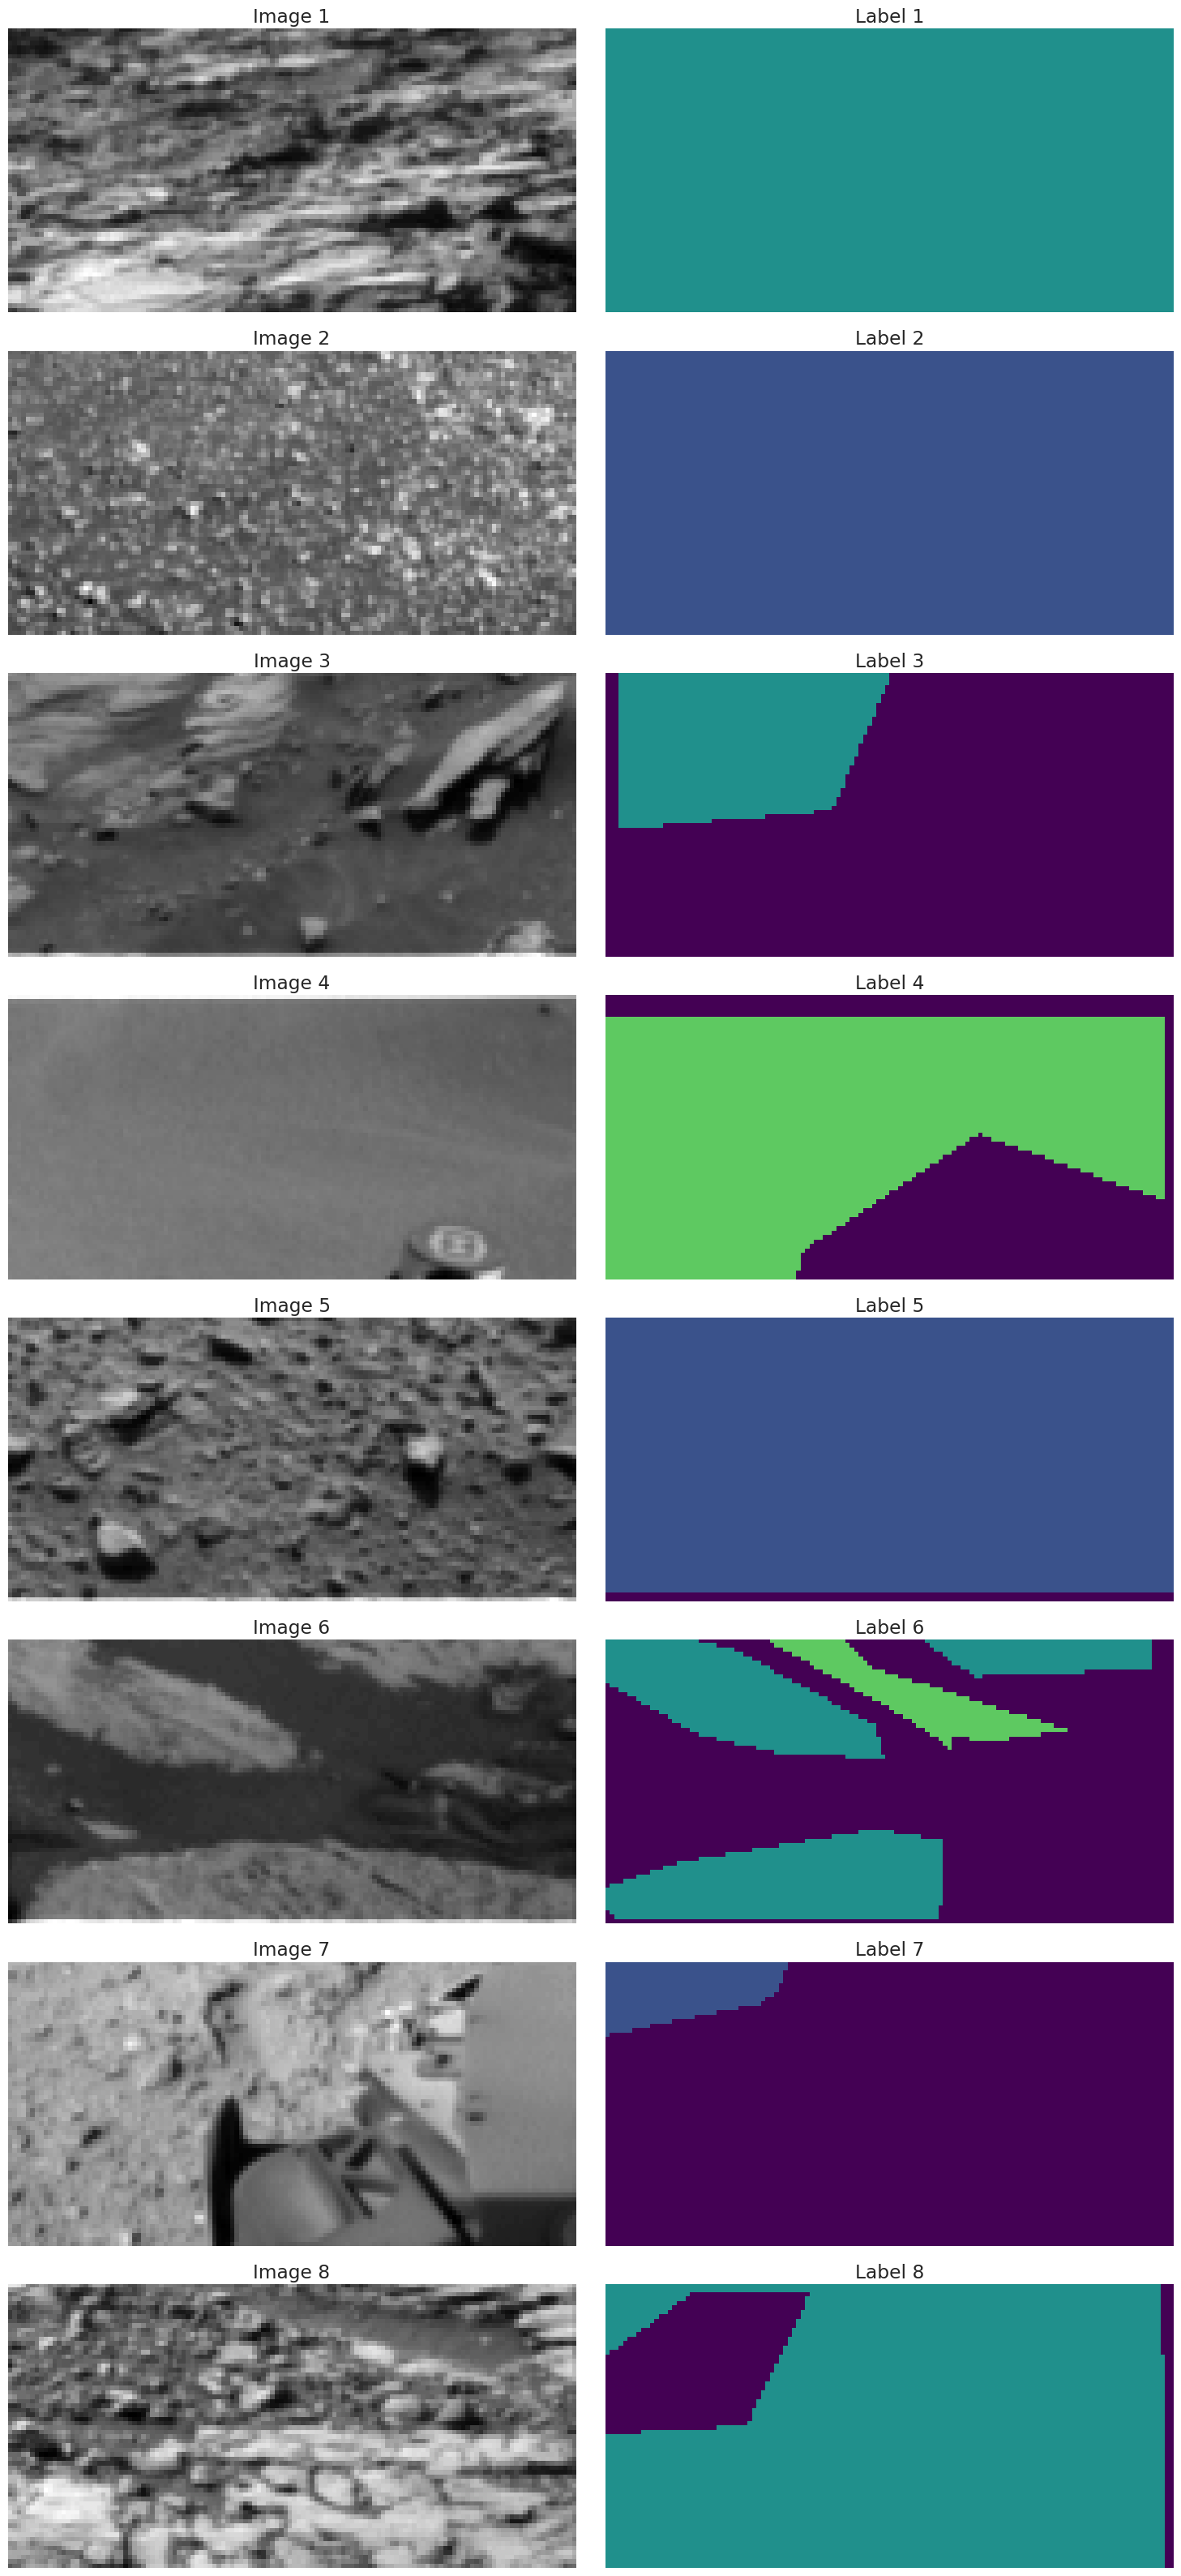

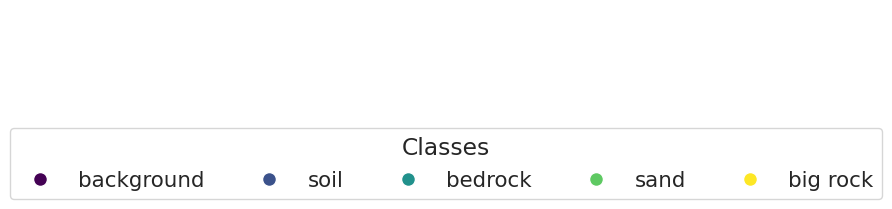

In [146]:
# Visualize examples from the training set
print("Visualizing examples from the training set:")
plot_sample_batch(train_dataset, num_samples=8)

## 🛠️ Models and Experiments

In [ ]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [ ]:
def get_unet_model(input_shape=(64, 128, 1), num_classes=NUM_CLASSES, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_') #first block with 32 filters
    d1 = tfkl.MaxPooling2D()(down_block_1) #reduce spacial complexity

    down_block_2 = unet_block(d1, 64, name='down_block2_') #another block
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # Bottleneck
    bottleneck = unet_block(d2, 128, name='bottleneck')

    # Upsampling path: increase spacial complexity
    u1 = tfkl.UpSampling2D()(bottleneck) #it is the opposition to maxpooling (simple pooling) with the nearest neighbour (ml approach)
    #not only possible layer: many alternatives (interpolation, bilinear, bicubic, ...)
    u1 = tfkl.Concatenate()([u1, down_block_2]) #concatenate this output and the output before maxpooling
    u1 = unet_block(u1, 64, name='up_block1_') #put concatenation inside unet block

    #alternative solution: transpose convolution (instead of upsampling does conv and upsampling together)!

    #we can replace concatenation with addition and multiplication
    #concatenation: preserve information but increase the number of parameters
    #addition: force the information to flow in 1 single point between upsampling (static with dynamic neuron) and convolutional (dynamic)
    #=> used to save memory and go deeper in the network: important to keep the same shape!

    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Concatenate()([u2, down_block_1])
    u2 = unet_block(u2, 32, name='up_block2_')

    # Output Layer: convolutional and not dense layer! it is almost the same because kernel size is 1
    #number of filters equal to the number of classes
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u2)
    #activation map which goes out from this layer has the same dimension of the input of the network

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

In [ ]:
model = get_unet_model()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

#there are 2 skip connections: very useful!

In [ ]:
# Define custom Mean Intersection Over Union metric -> expects only categorical cross entropy
#we can drop some classes like the background (labels_to _exclude: list)
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback: plot during the training the prediction and the images
#useful for debugging ex. I'm stuck in a local minima where the less represented class is never predicted
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, label, frequency=5):
        super().__init__()
        self.image_tensor = image  # The image tensor
        self.label_tensor = label  # The label tensor
        self.frequency = frequency


    
    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image = self.image_tensor
            label = self.label_tensor
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)        
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = NUM_CLASSES
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0])
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label.numpy(), colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [ ]:
# Compile the model
print("Compiling model...")
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), #not categorical crossentropy
    optimizer=tf.keras.optimizers.AdamW(),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)
print("Model compiled!")

In [ ]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

learning_rate = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    patience=15, 
    min_delta=1e-5
)

first_element = next(iter(val_dataset.take(1)))
image, label = first_element
viz_callback = VizCallback(image, label) #plot just the first image of validation set

In [ ]:
# Train the model
history = model.fit( #batch size already defined in definition of data loader
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, viz_callback, learning_rate],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = '/kaggle/working/UNet_'+str(final_val_meanIoU)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

In [ ]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)
del model

print(f"Model saved to {model_filename}")

## 📊 Prepare Your Submission

In [81]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [82]:
model = tfk.models.load_model(model_filename)
print(f"Model loaded from {model_filename}")

Model loaded from model_241201_163602.keras


In [89]:
X_test = X_test/255.0
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
Predictions shape: (10022, 64, 128)


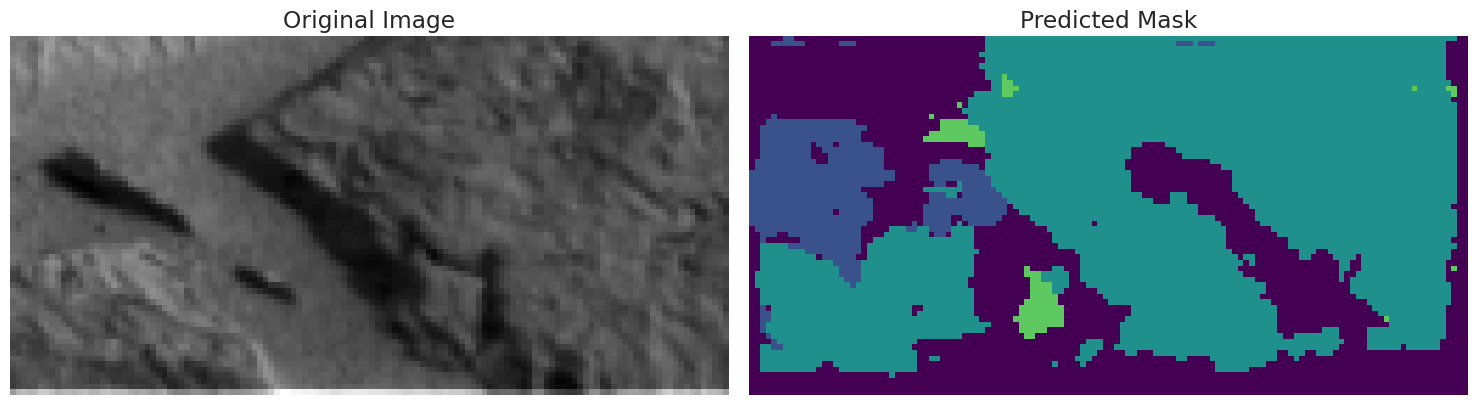

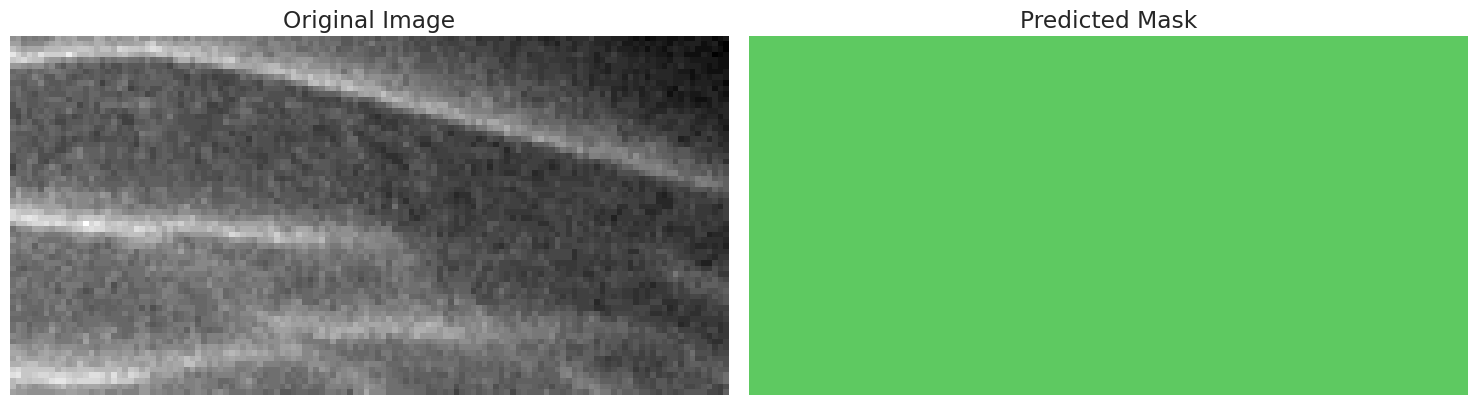

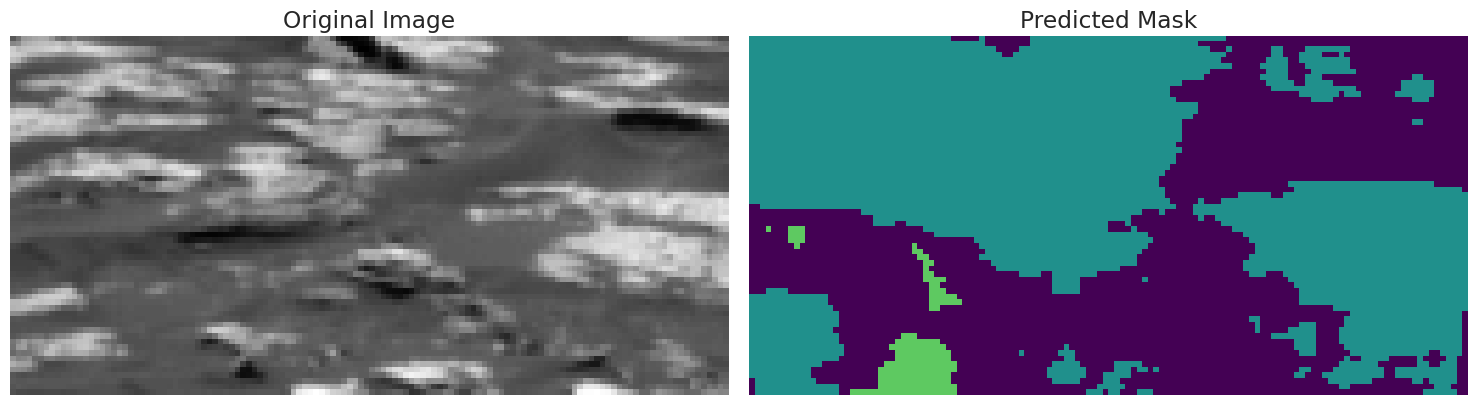

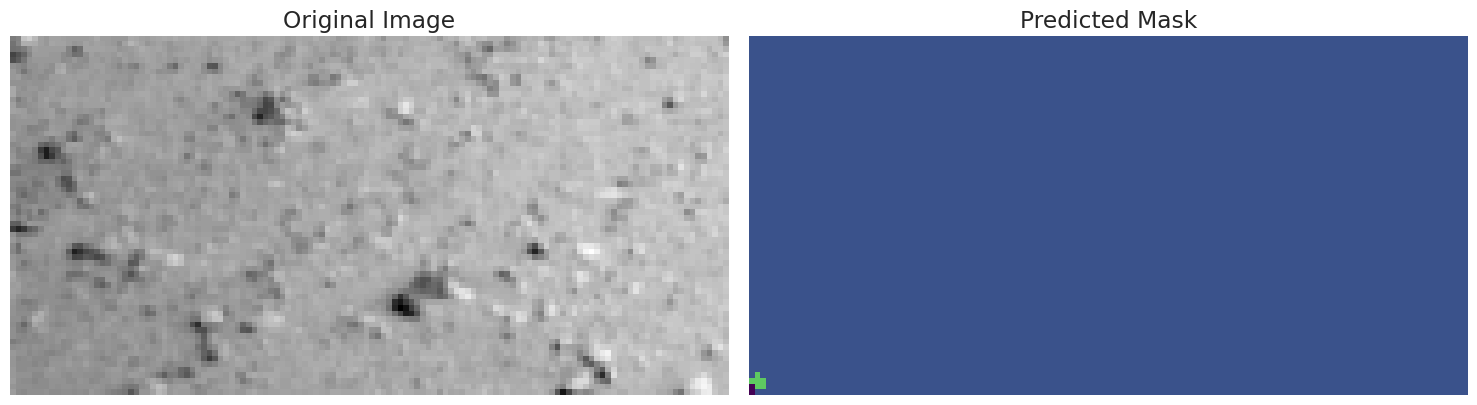

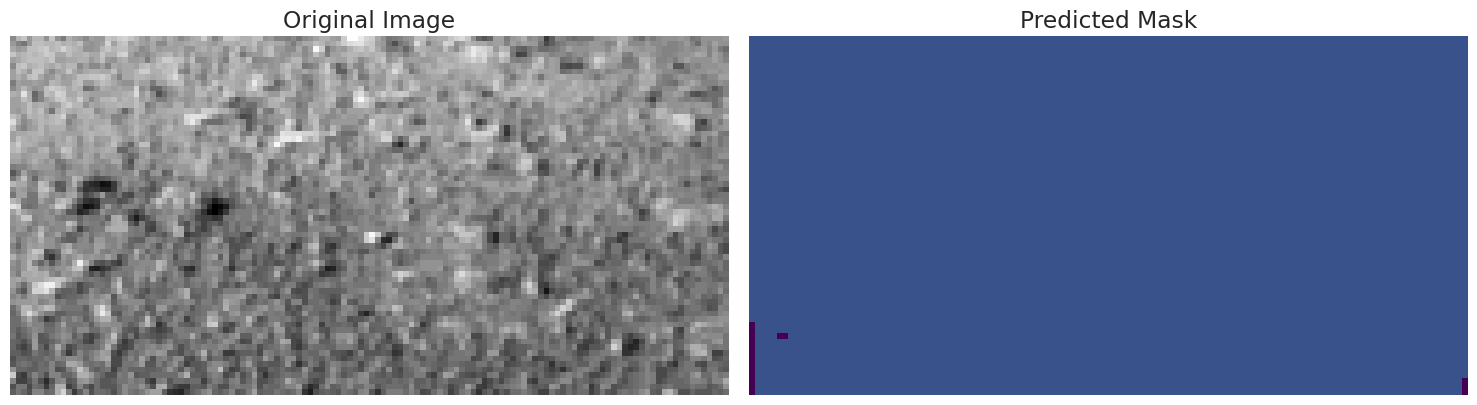

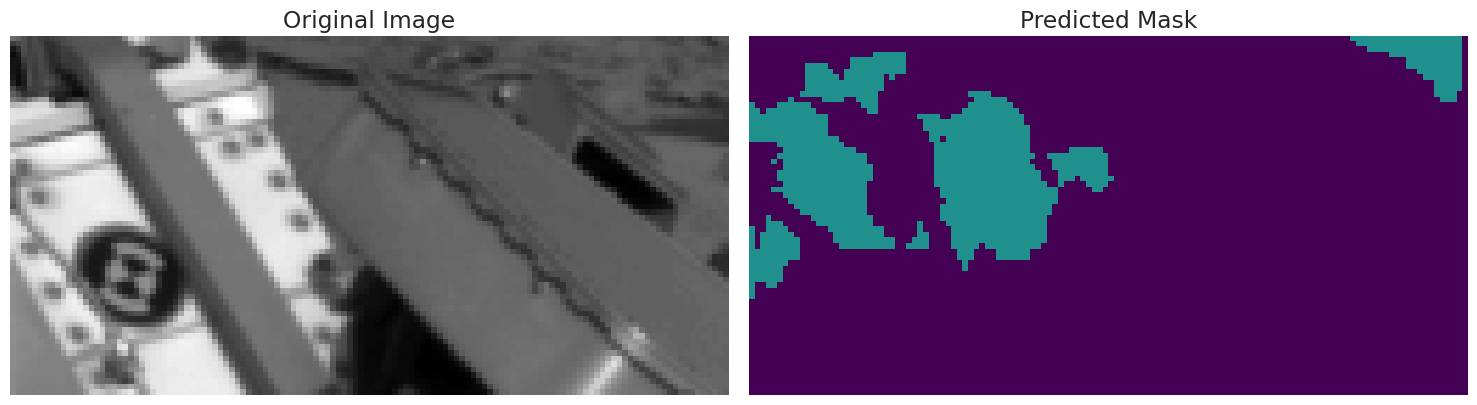

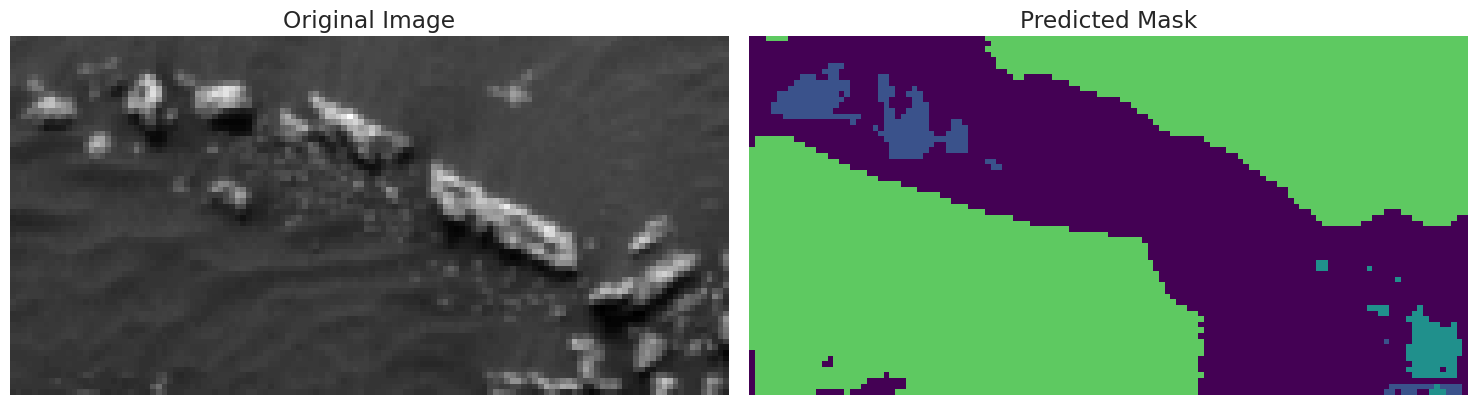

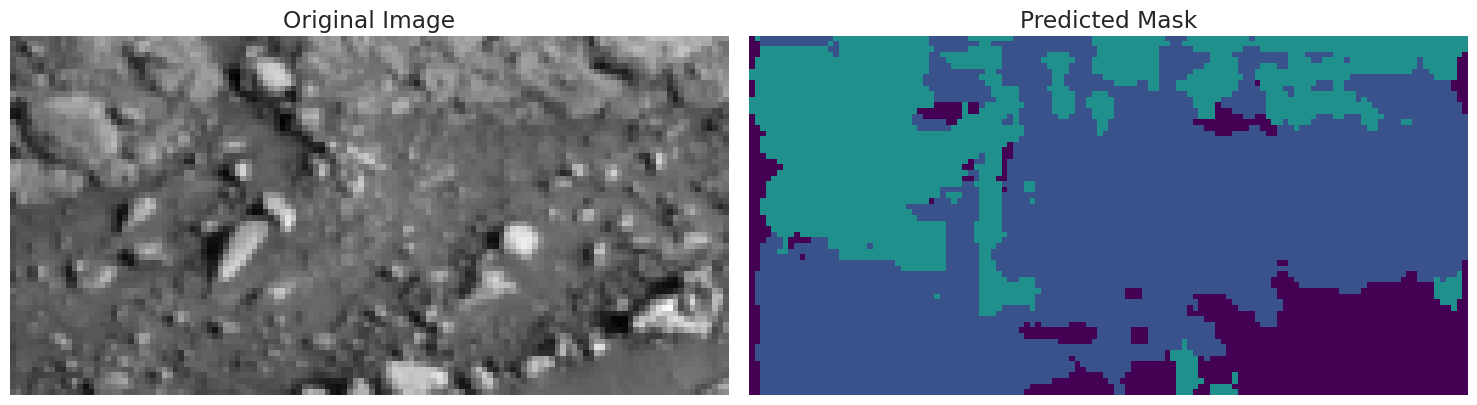

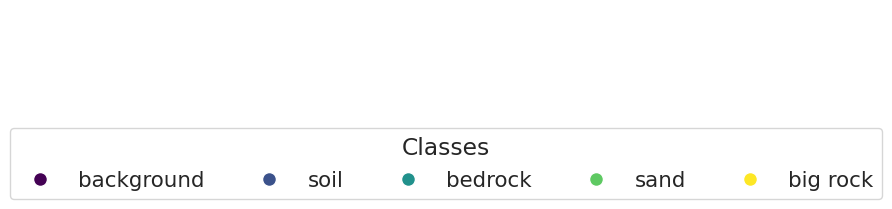

In [145]:
num_samples = 8
# Only take the first `num_samples` from X_test and preds
images = X_test[:num_samples]
predictions = preds[:num_samples]

# Adjust the number of classes to match the actual classes in the predictions (excluding 0)
num_classes = len(labels) #- 1 # Excluding background

# Create colormap based on the number of classes
colormap = create_segmentation_colormap(num_classes)

# Create a list to store the handles for the legend (only once)
handles = []

for i in range(num_samples):
    # Get the i-th image and its prediction
    image = images[i]
    predicted_mask = predictions[i]

    # Create figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot original image
    axes[0].set_title("Original Image")
    axes[0].imshow(image, cmap='gray')
    axes[0].axis('off')

    # Plot predicted mask
    axes[1].set_title("Predicted Mask")
    colored_pred = apply_colormap(predicted_mask, colormap)
    axes[1].imshow(colored_pred)
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

# After all images have been plotted, add the legend once
# We collect handles for the legend here, only once
for label_idx in category_map: 
    color = colormap[label_idx]  # Use array indexing, subtracting 1 to account for class 0 exclusion
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=classes[label_idx]))

# Create a single legend displayed at the bottom
fig, ax = plt.subplots(figsize=(10, 2))  # Make the figure wide enough for a horizontal legend
ax.legend(handles=handles, loc='center', bbox_to_anchor=(0.5, 0), title="Classes", ncol=len(category_map))
ax.axis('off')
plt.show()


In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)